# Установка необходимых пакетов
Запускать в случае работы на локальном ПК в окружении Anaconda (единожды)

# Загрузка аннотаций
Здесь откройте файл с аннотациями и считайте все данные

Формат аннотаций:

имя_файла upper_face_corner_x upper_face_corner_y bottom_face_corner_x bottom_face_corner_y left_eye_x left_eye_y right_eye_x right_eye_y nose_x nose_y left_mouth_x left_mouth_y right_mouth_x right_mouth_y

Координаты левого верхнего и правого нижнего углов описывающего прямоугольника заданы относительно изображения. Координаты лэндмарок - относительно описывающего прямоугольника

In [1]:
import sys
from collections import namedtuple

def load_annotations():
    annotation_row = namedtuple('annotation_row',
                                [
                                    'filename',
                                    'upper_face_corner_x',
                                    'upper_face_corner_y',
                                    'bottom_face_corner_x',
                                    'bottom_face_corner_y',
                                    'left_eye_x',
                                    'left_eye_y',
                                    'right_eye_x',
                                    'right_eye_y',
                                    'nose_x',
                                    'nose_y',
                                    'left_mouth_x',
                                    'left_mouth_y',
                                    'right_mouth_x',
                                    'right_mouth_y'
                                ])
    try:
        f = open('annotations.txt', 'r')
        data_annot = f.readlines() 
        f.close()
    except Exception as ex:
        print (ex)
        f.close()
        sys.exit(1)
        
    annotations = [annotation_row(*row.split()) for row in data_annot]

    return annotations

annotations = load_annotations()


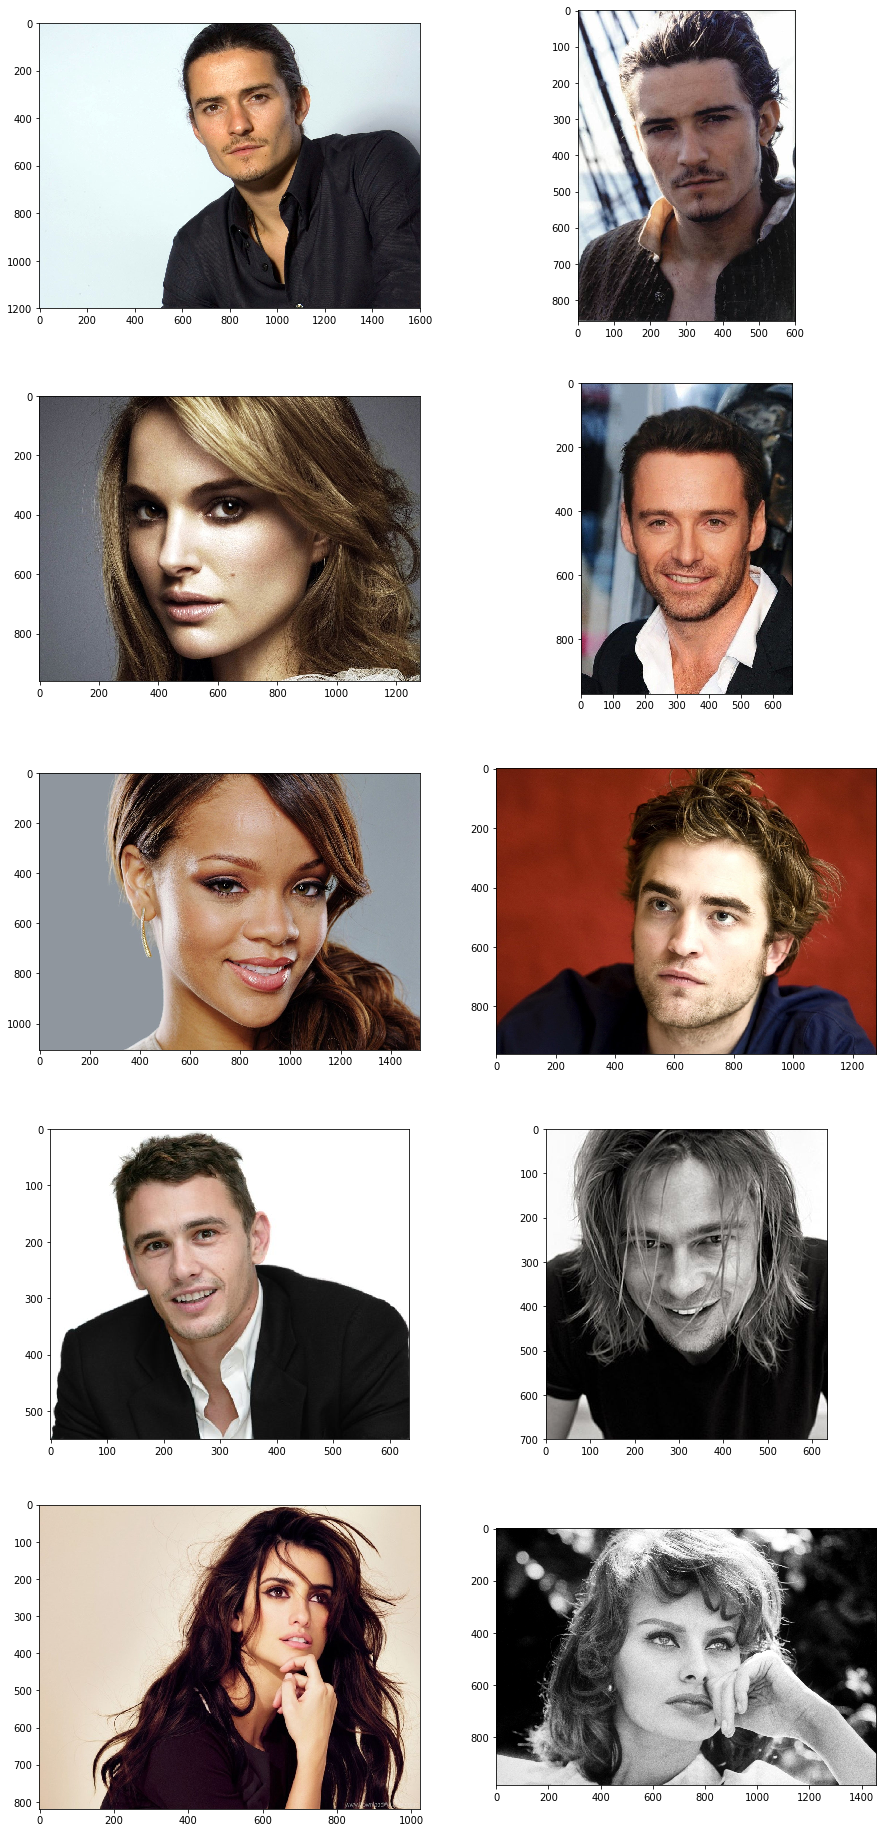

In [2]:
import cv2
import os
import sys
from matplotlib import pyplot as plt
%matplotlib inline  
IMAGES_FOLDER = "images"

def load_images(annotations):
    
    images = [cv2.imread(os.path.join(IMAGES_FOLDER, 
                                      annotation.filename))
              for annotation in annotations]

    return images

def show_images(images):
    '''
    Функция для ин-лайн отображения изображений
    Входные параметры:
    images: numpy uint8 массив изображений в формате BGR
    '''
    columns = 2
    images_count = len(images)
    plt.figure(figsize=(15,40))
    try:
        for i, image in enumerate(images):
            plt.subplot(images_count / columns + 1, columns, i + 1)
            image = image/255.
            plt.imshow(image[:,:,::-1])
    except Exception as ex:
        print('Ошибка открытия файлов')
        print(ex)
        sys.exit(1)

#print(annotations)
images = load_images(annotations)

show_images(images)

# Отображение изображений
Здесь загрузите и отобразите все изображения. Рекомендуется использовать реализованный метод отображения.

# Отображение рамок лиц и лэндмарок
Здесь отобразите изображения с нарисованными рамками и лэндмарками

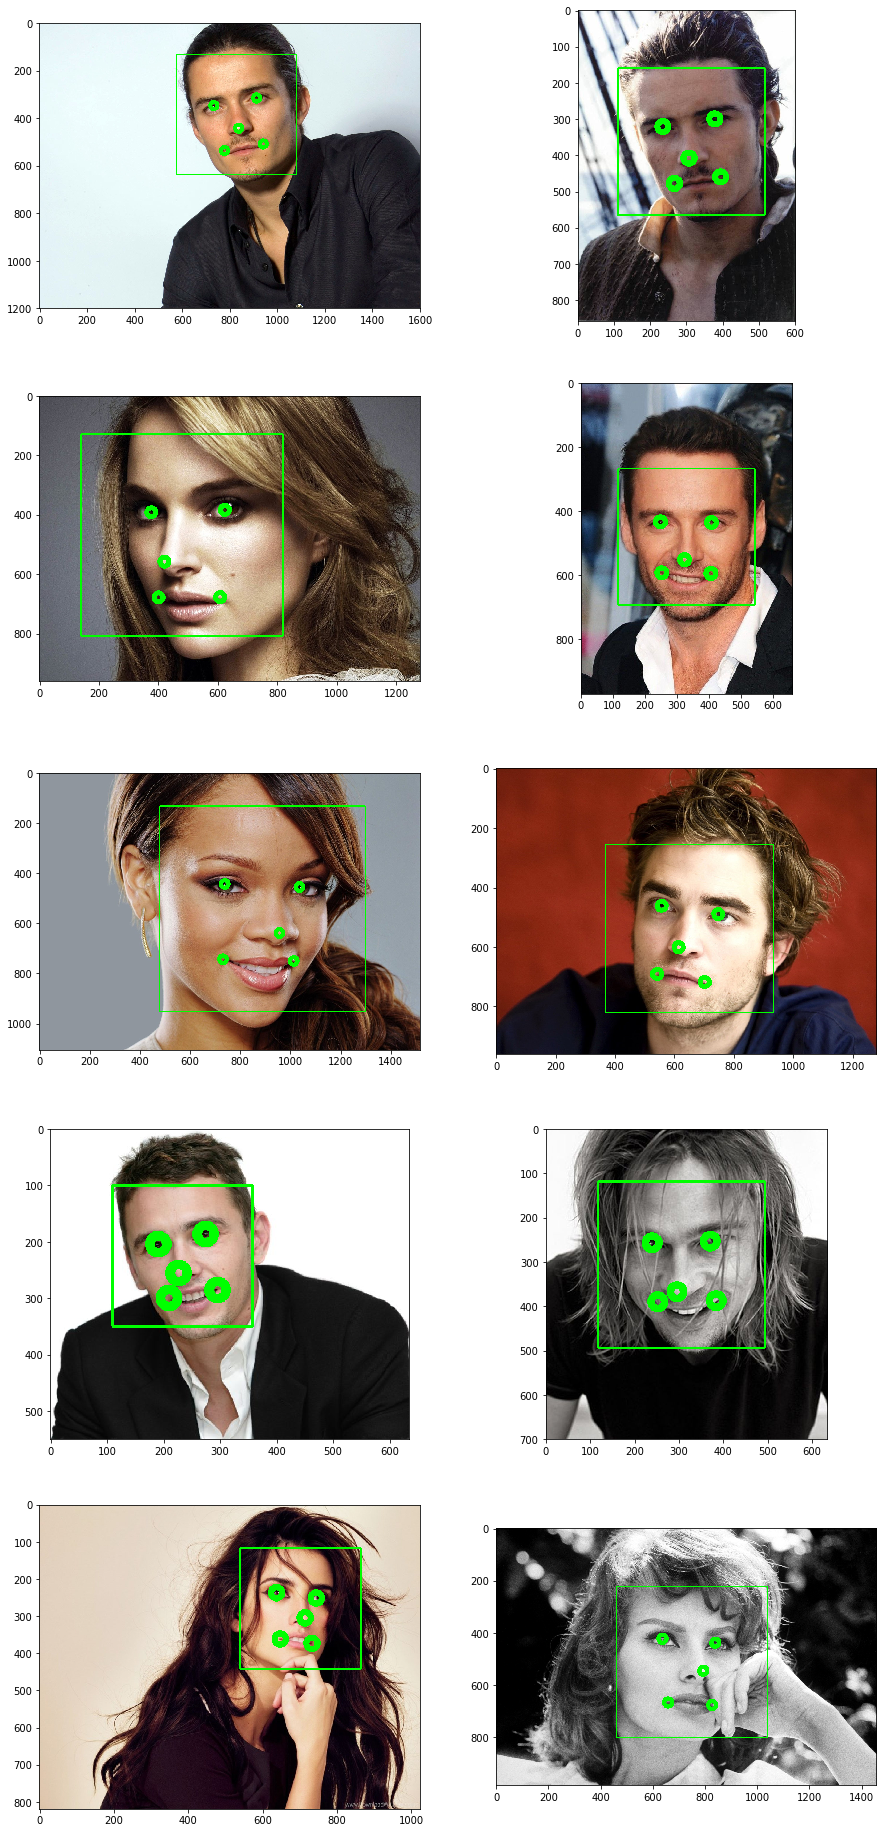

In [3]:
def annolize_image(image, annotation):
    #получаем размеры изображения
    image_size_x = image.shape[1]
    image_size_y = image.shape[0]
    #получаем координаты по данным из анотации
    
    upper_face_x = (image_size_x*float(annotation.upper_face_corner_x))
    upper_face_y = (image_size_y*float(annotation.upper_face_corner_y))
    
    bottom_face_x = (image_size_x*float(annotation.bottom_face_corner_x))
    bottom_face_y = (image_size_y*float(annotation.bottom_face_corner_y))
    
    front_corner = (int(upper_face_x), int(upper_face_y))
    back_corner = (int(bottom_face_x), int(bottom_face_y))
    
    #данные
    landmarks = {
        'left_eye': (
        int(upper_face_x + float(annotation.left_eye_x)*(bottom_face_x - upper_face_x)),
        int(upper_face_y + float(annotation.left_eye_y)*(bottom_face_y - upper_face_y))
        ),
        'right_eye': (
            int(upper_face_x + float(annotation.right_eye_x)*(bottom_face_x - upper_face_x)),
            int(upper_face_y + float(annotation.right_eye_y)*(bottom_face_y - upper_face_y))
        ),
        'nose': (
            int(upper_face_x + float(annotation.nose_x)*(bottom_face_x - upper_face_x)),
            int(upper_face_y + float(annotation.nose_y)*(bottom_face_y - upper_face_y))
        ),
        'left_mouth': (
            int(upper_face_x + float(annotation.left_mouth_x)*(bottom_face_x - upper_face_x)),
            int(upper_face_y + float(annotation.left_mouth_y)*(bottom_face_y - upper_face_y))
        ),
        'right_mouth': (
            int(upper_face_x + float(annotation.right_mouth_x)*(bottom_face_x - upper_face_x)),
            int(upper_face_y + float(annotation.right_mouth_y)*(bottom_face_y - upper_face_y))
        )
    }
    return (front_corner, back_corner, landmarks)


def draw_all_and_show_images(annotations):
    images = load_images(annotations)
    

    for i, image in enumerate(images):
        annotation = annotations[i]
                
        front_corner, back_corner, landmarks = annolize_image(image, annotation)
        for marks in landmarks.values():
            img = cv2.circle(image, marks, 15, (0, 255, 0), 15)
            img = cv2.rectangle(img, front_corner, back_corner, (0, 255, 0), 3)
    show_images(images)
    
draw_all_and_show_images(annotations)

# Наложение модели очков
Здесь реализуйте автоматическое наложение очков на лица на основании ключевых точек (лэндмарок) и отобразите

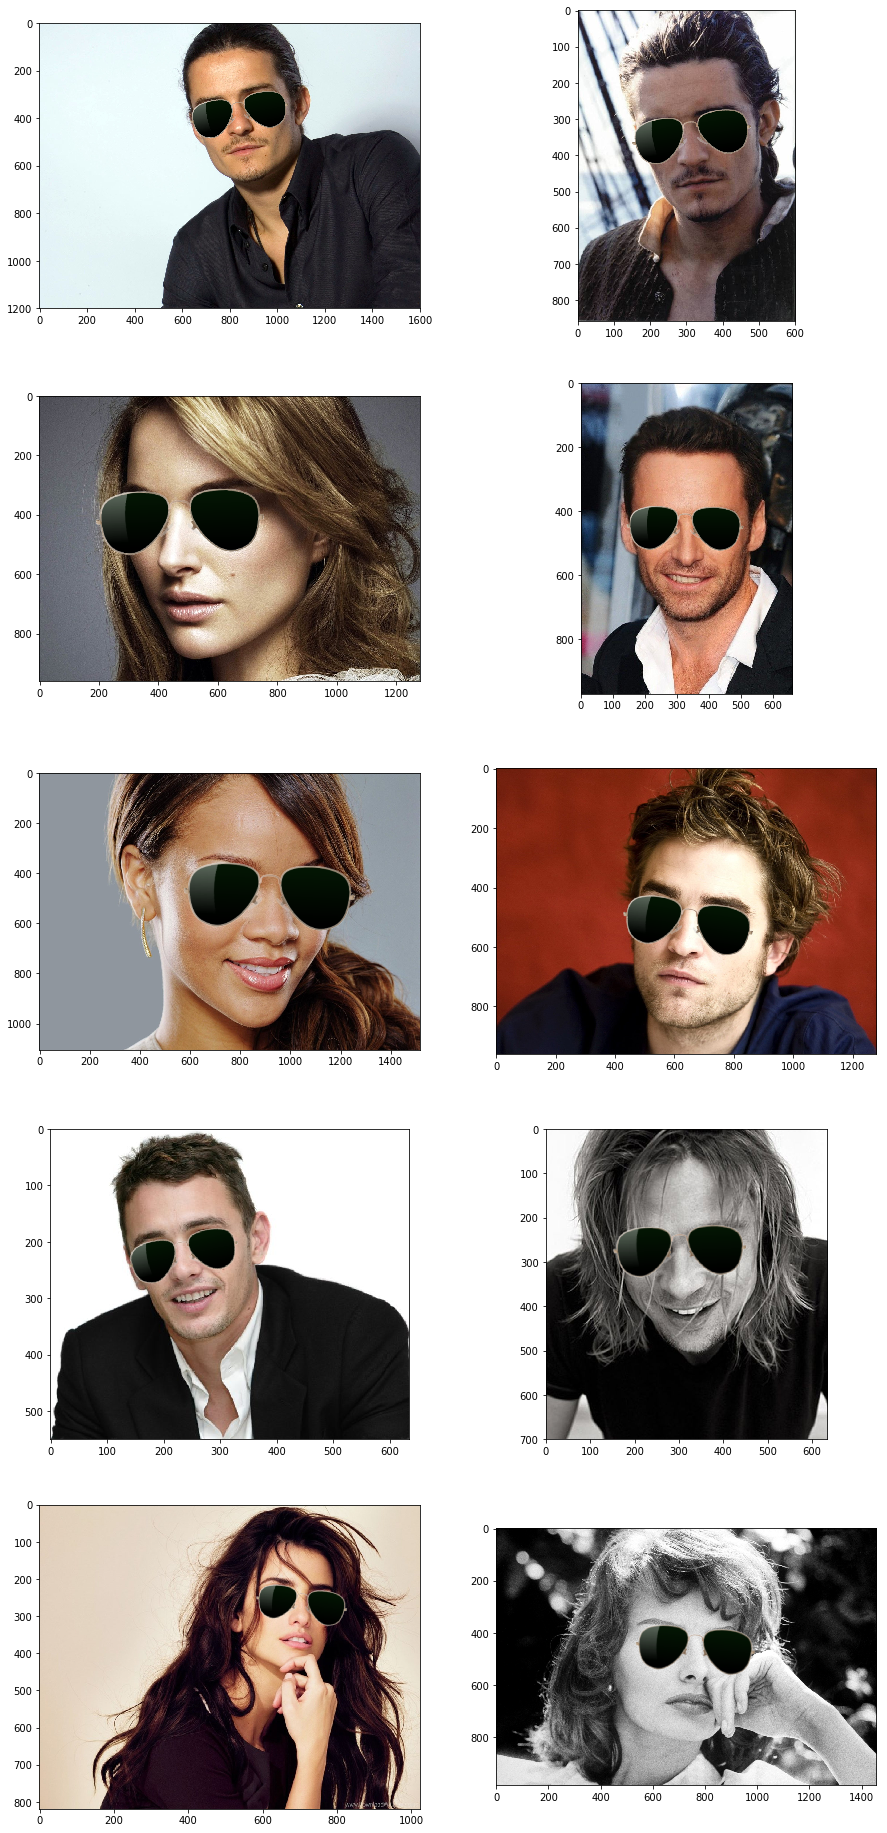

In [7]:
import numpy as np
#не понимаю, как это работает. нашел пример в статье)
def overlay_image_alpha(img, img_overlay, pos, alpha_mask):
    x, y = pos

    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    channels = img.shape[2]

    alpha = alpha_mask[y1o:y2o, x1o:x2o]
    alpha_inv = 1.0 - alpha

    for c in range(channels):
        img[y1:y2, x1:x2, c] = (alpha * img_overlay[y1o:y2o, x1o:x2o, c] + alpha_inv * img[y1:y2, x1:x2, c])

def get_middle(p1, p2):
    return int((p1[0] + p2[0]) / 2), int((p1[1] + p2[1]) / 2)

def rotate_bound(image, angle):
    (height, weight) = image.shape[:2]
    (cX, cY) = (weight // 2, height // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    new_weight = int((height * sin) + (weight * cos))
    new_height = int((height * cos) + (weight * sin))

    M[0, 2] += (new_weight / 2) - cX
    M[1, 2] += (new_height / 2) - cY

    return cv2.warpAffine(image, M, (new_weight, new_height))

def tuple_substract(t1, t2):
    return (t1[0] - t2[0], t1[1] - t2[1])


def add_glasses_and_show_images(annotations):
    glasses = cv2.imread("glasses.png", -1)
    images = load_images(annotations)
    processed_images = []
    for image_num in range(10):
        ann = annotations[image_num]
        photo = images[image_num]
        upper_face_corner, bottom_face_corner, landmarks_dict = annolize_image(photo, ann)

        eyes_dist = np.linalg.norm(np.array(landmarks_dict['left_eye']) - np.array(landmarks_dict['right_eye']))
        nose_center = landmarks_dict['nose']
        glasses_size = glasses.shape[0]
        resize_scale = (eyes_dist/glasses_size) * 0.95
        glasses = cv2.resize(glasses, (0,0), fx=resize_scale, fy=resize_scale)

        eyes_center = get_middle(landmarks_dict['right_eye'], landmarks_dict['left_eye'])


        face_center = (int((5*eyes_center[0] + 3*nose_center[0])/8), int((9*eyes_center[1] + 1*nose_center[1])/10))

        glasses_bottom_corner = (face_center[0] + glasses.shape[1], face_center[1] + glasses.shape[0])
        glasses_center = get_middle(face_center, glasses_bottom_corner)
        
        
        glasses_top_center_dist = tuple_substract(glasses_center, face_center)
        glasses_plot_point = tuple_substract(face_center, glasses_top_center_dist)

        left_eye = np.array(landmarks_dict['left_eye'])
        right_eye = np.array(landmarks_dict['right_eye'])

        p1, p2, p3 = left_eye, right_eye, np.array([0, photo.shape[0]])


        angle = np.rad2deg(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))

        rotated_glasses = rotate_bound(glasses, angle)
        overlay_image_alpha(photo,
                            rotated_glasses[:, :, 0:3],
                            glasses_plot_point,
                            rotated_glasses[:, :, 3] / 255.0)

        processed_images.append(photo)

    show_images(processed_images)

add_glasses_and_show_images(annotations)